In [ ]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

# from utils.preprocessing import extract_log_mel_feats
# run git log чтобы посмотреть предыдущие версии кода, где не было исправлений

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):

    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

In [ ]:
train_folder = '/content/drive/MyDrive/Colab Notebooks/hse-acoustic-event-detection-2022/audio_train/train/'
test_folder = '/content/drive/MyDrive/Colab Notebooks/hse-acoustic-event-detection-2022/audio_test/test/'

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

In [ ]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

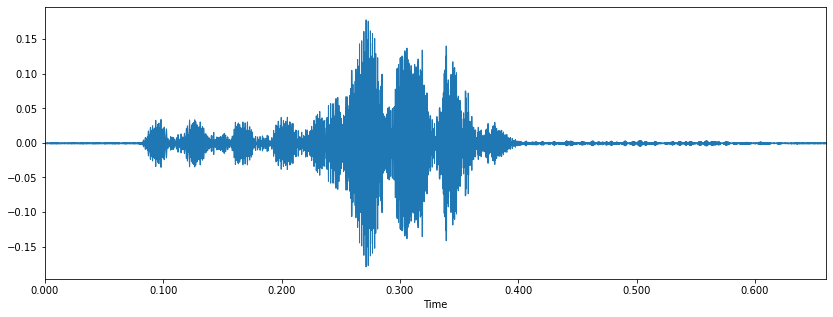

In [ ]:
import IPython.display as ipd

wav, sr = librosa.load("/content/drive/MyDrive/Colab Notebooks/hse-acoustic-event-detection-2022/audio_test/test/3f10054bcbedcf1cabb7.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

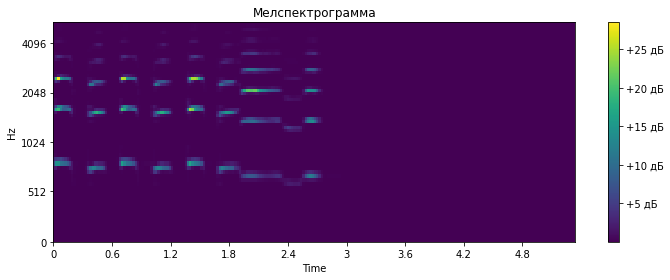

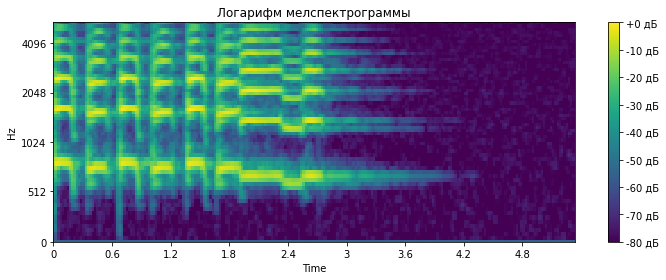

In [ ]:
wav_data, sr = load(os.path.join(test_folder, '0a9f4e787d8d2af55683.wav'), sr=sample_rate)
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [ ]:
path_to_csv = os.path.join('/content/drive/MyDrive/Colab Notebooks/hse-acoustic-event-detection-2022/', 'train.csv')

pickle_train_path = os.path.join('train.pickle')
# pickle_test_path = os.path.join('./data', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]

# extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

Total files: 5683


5671it [32:02,  2.90it/s]

In [ ]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.flat = nn.Flatten()
        
        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(33856, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [ ]:
random_input = torch.randn(1, 1, 64, 64, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[-0.1912,  1.0770,  0.5414,  0.5257,  0.4178, -0.0680, -1.0875,  0.5418,
          0.8887,  0.4586, -0.1551,  0.7549, -0.8200, -0.4106, -0.6387, -0.5409,
          0.6181,  0.4464, -0.3163, -0.6492,  1.4075, -0.2522, -0.1242,  0.6913,
          2.0334, -0.8035, -0.1514, -1.3150,  0.1605, -1.8944, -0.7588,  0.5736,
          0.2777, -0.4011, -0.9603,  0.4418,  1.4459, -2.2702,  0.3622, -0.8611,
         -0.0772]], grad_fn=<AddmmBackward0>)


In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

4.295457363128662


In [ ]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [ ]:
def prepare_shape(feature):
    tmp = feature
    N = 64
    while tmp.shape[1] < N:
        tmp = np.hstack((tmp, tmp))
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [ ]:
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [ ]:
from torch.utils.data import Dataset


class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return self.x[idx], self.y[idx]
        return self.x[idx]

In [ ]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

14


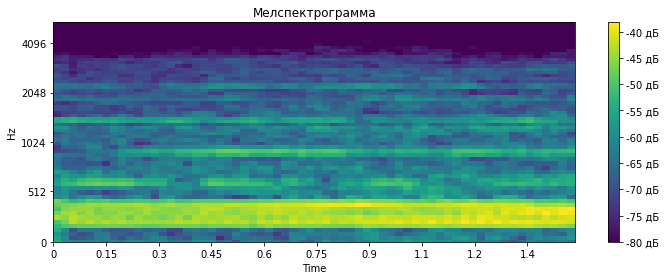

In [ ]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 3.5233301063378653
train accuracy: 0.12471841081302477
mean val loss: 6.519802832603455
val accuracy: 0.06625
epoch # 1
mean train loss: 2.937739584843318
train accuracy: 0.22056113045259063
mean val loss: 4.8500741720199585
val accuracy: 0.10625
epoch # 2
mean train loss: 2.6726132611433666
train accuracy: 0.2750358386237968
mean val loss: 4.476622891426087
val accuracy: 0.095
epoch # 3
mean train loss: 2.5137122333049775
train accuracy: 0.3168134343641204
mean val loss: 3.821745014190674
val accuracy: 0.125
epoch # 4
mean train loss: 2.4016366203626
train accuracy: 0.3483514233053451
mean val loss: 4.109173703193664
val accuracy: 0.09875
epoch # 5
mean train loss: 2.3119435578584673
train accuracy: 0.36964980544747084
mean val loss: 3.676590883731842
val accuracy: 0.1625
epoch # 6
mean train loss: 2.2623835136493047
train accuracy: 0.3805037886545157
mean val loss: 4.1331430792808534
val accuracy: 0.13375
epoch # 7
mean train loss: 2.1560155640045804
train 

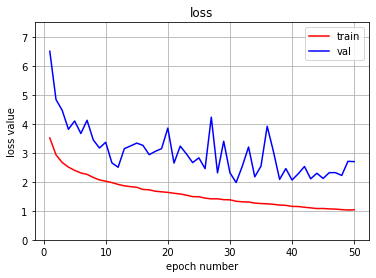

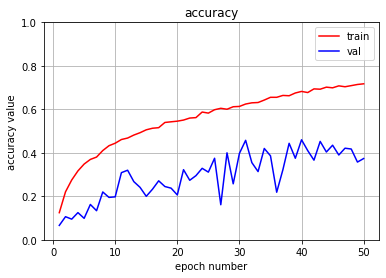

In [ ]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install torch-audiomentations
!pip install efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import glob
import copy
import tqdm
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding

import torchaudio
import torchaudio.transforms as T
from torch_audiomentations import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Constants**

In [ ]:
# Randomness
SEED = 451

# Paths
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/hse-acoustic-event-detection-2022'
TRAIN_DIR = os.path.join(DATA_DIR, 'audio_train', 'train')
TEST_DIR = os.path.join(DATA_DIR, 'audio_test', 'test')

# Features 
SAMPLE_RATE = 16000
FFT_SIZE = 1024
WIN_LEN = 512
HOP_LEN = WIN_LEN // 2
N_MELS = 128

# Dataset
BATCH_SIZE = 64
NUM_CLASSES = 41

# Models parameters
EMB_SIZE = 256
LEARNING_RATE = 1e-3
N_EPOCHS = 20
DEVICE = 'cuda:0'

**Setup randomness**

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Data preprocessing**

In [ ]:
sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

print("Train dir len:", len(os.listdir(TRAIN_DIR)))
print("Test dir len:", len(os.listdir(TEST_DIR)))
print("Sample submission df shape:", sample_submission_df.shape)
print("Train df shape:", train_df.shape)

Train dir len: 5683
Test dir len: 3790
Sample submission df shape: (3790, 2)
Train df shape: (5683, 2)


In [ ]:
print("Unique labels:", len(train_df.label.unique()))

# Dummy
sample_submission_df['label_encoded'] = sample_submission_df['label']

classes_dict = {cl: i for i, cl in enumerate(train_df.label.unique())}
idx_to_class_dict = {val: key for key, val in classes_dict.items()}
train_df['label_encoded'] = train_df['label'].apply(lambda x: classes_dict[x])
train_df.head()

Unique labels: 41


,fname,label,label_encoded
0,8bcbcc394ba64fe85ed4.wav,Finger_snapping,0
1,00d77b917e241afa06f1.wav,Squeak,1
2,17bb93b73b8e79234cb3.wav,Electric_piano,2
3,7d5c7a40a936136da55e.wav,Harmonica,3
4,17e0ee7565a33d6c2326.wav,Snare_drum,4


In [ ]:
# Divide train into train and eval subsets with saved labels distributions
train_df, eval_df = train_test_split(train_df, train_size=0.80, stratify=train_df['label_encoded'])
print("Train shape: %s\nEval shape: %s" % (train_df.shape, eval_df.shape))

Train shape: (4546, 3)
Eval shape: (1137, 3)


**Utils**

In [ ]:
def find_most_loud_period(wav, segment_size):
    
    result = None
    if wav.shape[1] < segment_size:
        num_repeats = np.ceil(segment_size / wav.shape[1]).astype(int)
        wav = wav.repeat((1, num_repeats))[:, :segment_size]
        result = wav
    elif wav.shape[1] == segment_size:
        result = wav
    else:
        loud_idx = wav.argmax(axis=1)
        if loud_idx < segment_size // 2:
            result = wav[:, :segment_size]
        elif loud_idx > wav.shape[1] - segment_size // 2:
            result = wav[:, -segment_size:]
        else:
            result = wav[:, loud_idx - segment_size // 2 : loud_idx + segment_size // 2]
    return result


def get_class_weights(y):
    
    _, counts = np.unique(y, return_counts=True)
    weights = counts / y.shape[0]
    weights = weights.min() / weights
    weights = np.array([weights[int(y_)] for y_ in y])
    return weights


def apply_aug_transform(wav, sample_rate):
    
    apply_augmentation = Compose(transforms=[
        AddColoredNoise(min_snr_in_db=-10, max_snr_in_db=10, p=0.3),
        Gain(min_gain_in_db=-15.0, max_gain_in_db=5.0, p=0.3),
        Shift(min_shift=-0.1, max_shift=0.1, shift_unit="seconds", p=0.3),
        
    ], shuffle=True)
    wav = apply_augmentation(wav, sample_rate=sample_rate)
    return wav


def init_weights(module):
    
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        torch.nn.init.xavier_normal_(module.weight)
    if type(module) == nn.Linear and module.bias is not None:
        module.bias.data.fill_(0.01)
                

def plot_history(history, title, ylabel):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Epoch")
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['eval_loss'], label='eval')
    plt.xticks(np.arange(len(history['train_loss'])), np.arange(len(history['train_loss'])))
    plt.legend()
    plt.show()

In [ ]:
class AED_Dataset(Dataset):
    
    def __init__(self, path_to_wav_dir, x: np.ndarray, y: np.ndarray, augment_factor=1):
        self.path_to_wav_dir = path_to_wav_dir
        self.x = self.x = np.array(list(x) * augment_factor)
        self.y = np.array(list(y) * augment_factor)
        self.augment_factor = augment_factor
    
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(
            os.path.join(self.path_to_wav_dir, self.x[idx]), normalize=True)
        if idx % self.augment_factor != 0:
            wav = apply_aug_transform(wav.unsqueeze(0), sr).squeeze(0)
        
        # Find loudest timestamp and get 2 seconds around it
        wav = find_most_loud_period(wav, segment_size=sr * 3)
        return self.x[idx], wav, self.y[idx]
    
    def __len__(self):
        return len(self.y)

In [ ]:
train_dataset = AED_Dataset(
    TRAIN_DIR, 
    train_df['fname'], 
    train_df['label_encoded'],
    augment_factor=10,
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = AED_Dataset(
    TEST_DIR, 
    sample_submission_df['fname'], 
    sample_submission_df['label_encoded'],
)
test_loader = DataLoader(test_dataset, batch_size=128)

eval_dataset = AED_Dataset(
    TRAIN_DIR, 
    eval_df['fname'], 
    eval_df['label_encoded']
)
eval_loader = DataLoader(eval_dataset, batch_size=128)

**Models implementation**

In [ ]:
class AMSoftmaxLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.4):
        
        super(AMSoftmaxLoss, self).__init__()
        self.s = s
        self.m = m
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x, labels):        
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, dim=1)

        x = F.normalize(x, dim=1)

        wf = self.fc(x)
        numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return -torch.mean(L)

In [ ]:
class EfficientNet_AED_Extractor(nn.Module):
    def __init__(self, efficient_net_version, n_classes, sample_rate, n_fft, win_length, hop_length, n_mels):
        super(EfficientNet_AED_Extractor, self).__init__()
        self.ms = T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, 
                                   win_length=win_length, hop_length=hop_length, 
                                   n_mels=n_mels, normalized=True)
        self.to_db = T.AmplitudeToDB()
        
        assert efficient_net_version is not None
        self.efficientnet_model = EfficientNet.from_pretrained(
            'efficientnet-%s' % efficient_net_version
        )
        self.efficientnet_model._conv_stem = Conv2dStaticSamePadding(
            1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=(128, 188)
        )
        self.fc = nn.Linear(1000, EMB_SIZE, bias=True)
        self.dropout = nn.Dropout(0.3)
        self.am_softmax_loss = AMSoftmaxLoss(EMB_SIZE, n_classes, s=10.0, m=0.5)
        
    def forward(self, x, labels, return_type='loss'):
        x = self.ms(x)
        x = self.to_db(x)
        x = F.relu(self.efficientnet_model(x))
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        if return_type == 'emb':
            return x
        loss = self.am_softmax_loss(x, labels)
        if return_type == 'loss':
            return loss
        elif return_type == 'both':
            return x, loss

In [ ]:
class EfficientNet_AED_Classifier(nn.Module):
    def __init__(self, n_classes, extractor):
        super(EfficientNet_AED_Classifier, self).__init__()
        self.extractor = extractor
        for param in self.extractor.parameters():
            param.requires_grad = False
            
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(EMB_SIZE, 256, bias=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, n_classes, bias=True)
        
    def forward(self, x, extract_emb=False):
        x = self.extractor(x, None, 'emb')
        if extract_emb:
            return x
        
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        # x = F.softmax(self.fc2(x))
        x = self.fc2(x)
        return x

**NN models training**

In [ ]:
# Inference functions

def extract_embeddings(model, data_loader, device=DEVICE):
    
    with torch.no_grad():
        model.eval()
        model.to(device)
        fnames, labels = [], torch.Tensor([])
        embeddings = torch.Tensor([]).to(device)
        for fname, X, y in tqdm.tqdm(data_loader):
            X = X.to(device)
            emb = model(X, extract_emb=True)
            fnames += list(fname)
            labels = torch.cat((labels, y), 0)
            embeddings = torch.cat((embeddings, emb.squeeze()), 0)

        embeddings = embeddings.detach().cpu().numpy()
        embeddings_info = [{'fname': fname, 'emb': emb, 'label': label} 
                           for fname, emb, label in zip(fnames, embeddings, labels)]
    return embeddings_info


def predict_classifier(model, data_loader, return_probs=False, device=DEVICE):
    
    model.eval()
    model.to(device)
    preds, trues = torch.Tensor([]).to(device), torch.Tensor([])
    for _, X, y in tqdm.tqdm(data_loader):
        X = X.to(device)
        pred = F.softmax(model(X))
        # pred = model(X)
        
        trues = torch.cat((trues, y), 0)
        if return_probs:
            preds = torch.cat((preds, pred.squeeze()), 0)
        else:
            preds = torch.cat((preds, pred.argmax(axis=1).squeeze()), 0)
    
    trues = trues.detach().cpu().numpy()
    preds = preds.detach().cpu().numpy()
    return trues, preds

In [ ]:
def train_one_epoch_extractor(current_epoch, model, train_loader, eval_loader, log_every, device):
    
    global best_loss
    
    model.train()
    train_loss = []
    pbar = tqdm.tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (_, batch_x, batch_y) in pbar:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        loss = model(batch_x, batch_y, return_type='loss')
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        if i != 0 and i % log_every == 0:
            pbar.set_description("Train Loss: %s" % np.mean(train_loss))

    # Save loss info
    model.eval()
    eval_loss = []
    for _, batch_x, batch_y in eval_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        loss = model(batch_x, batch_y, return_type='loss')
        eval_loss.append(loss.item())
    eval_loss = np.mean(eval_loss)
    train_loss = np.mean(train_loss)
    
    if eval_loss < best_loss:
        print("New best eval loss. Saving copy of the model.")
        best_loss = eval_loss
        save_dict = {
            'epoch': current_epoch,
            'loss': eval_loss,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(save_dict, 'aed_extractor.pth')
        
    print("Eval loss: %s\n" % eval_loss)
    scheduler.step(eval_loss)
    
    return train_loss, eval_loss


def train_one_epoch_classifier(current_epoch, model, train_loader, eval_loader, log_every, device):
    
    global best_f1
    model.train()
    train_loss = []
    pbar = tqdm.tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (_, batch_x, batch_y) in pbar:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        batch_out = model(batch_x)
        loss = criterion(batch_out, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        if i != 0 and i % log_every == 0:
            pbar.set_description("Train Loss: %s" % np.mean(train_loss))
            
    y_true, y_pred = predict_classifier(model, eval_loader, device=device)
    f1 = f1_score(y_true, y_pred, average='macro')
    scheduler.step(f1)
    print("Eval F1-score: %s" % f1)
    
    if f1 > best_f1:
        print("New best f1-score. Saving copy of the model.")
        save_dict = {
            'epoch': current_epoch,
            'f1_score': f1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
        }
        torch.save(save_dict, 'aed_classifier.pth')
        best_f1 = f1
    
    return np.mean(train_loss), f1
        

def train(model, train_loader, eval_loader, epoch_trainer, n_epochs, device):
    
    model.to(device)
    train_losses, eval_losses = [], []
    for i in range(n_epochs):
        print("Training: %s/%s epochs." % (i + 1, n_epochs))
        train_loss, eval_loss = epoch_trainer(i, model, train_loader, eval_loader, log_every=2, device=device)
        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        
    history = {'train_loss': train_losses, 'eval_loss': eval_losses}
    return model, history

**Extractor training**

Skip this section if you're using pretrained model

In [ ]:
aed_extractor = EfficientNet_AED_Extractor(
    efficient_net_version='b0',
    n_classes=41,
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_fft=FFT_SIZE,
)
aed_extractor = aed_extractor.apply(init_weights)

optimizer = optim.SGD(aed_extractor.parameters(), lr=1e-3, momentum=0.96)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.75, mode='min')

best_loss = 10.0

aed_extractor, history_ext = train(
    aed_extractor, 
    train_loader, 
    eval_loader, 
    epoch_trainer=train_one_epoch_extractor,
    n_epochs=10, 
    device=DEVICE
)

Loaded pretrained weights for efficientnet-b0
Training: 1/10 epochs.


Train Loss: 6.590686849736295: 100%|██████████| 711/711 [06:15<00:00,  1.89it/s]


New best eval loss. Saving copy of the model.
Eval loss: 4.593662261962891

Training: 2/10 epochs.


Train Loss: 3.2225824990185337: 100%|██████████| 711/711 [06:23<00:00,  1.85it/s]


New best eval loss. Saving copy of the model.
Eval loss: 3.2965098487006292

Training: 3/10 epochs.


Train Loss: 1.7641730607813422: 100%|██████████| 711/711 [05:28<00:00,  2.17it/s]


New best eval loss. Saving copy of the model.
Eval loss: 3.0527969466315374

Training: 4/10 epochs.


Train Loss: 1.126016294151419: 100%|██████████| 711/711 [04:48<00:00,  2.46it/s]


New best eval loss. Saving copy of the model.
Eval loss: 2.9121980402204724

Training: 5/10 epochs.


Train Loss: 0.8441423258197962: 100%|██████████| 711/711 [04:39<00:00,  2.55it/s]


New best eval loss. Saving copy of the model.
Eval loss: 2.899505615234375

Training: 6/10 epochs.


Train Loss: 0.7048145693984883: 100%|██████████| 711/711 [05:06<00:00,  2.32it/s]


Eval loss: 3.0554121335347495

Training: 7/10 epochs.


Train Loss: 0.6003868301646619: 100%|██████████| 711/711 [04:36<00:00,  2.57it/s]


New best eval loss. Saving copy of the model.
Eval loss: 2.8948598437839084

Training: 8/10 epochs.


Train Loss: 0.49646715456213797: 100%|██████████| 711/711 [05:33<00:00,  2.13it/s]


Eval loss: 3.0445627636379666

Training: 9/10 epochs.


Train Loss: 0.4398659630148094: 100%|██████████| 711/711 [04:36<00:00,  2.58it/s]


Eval loss: 2.927376906077067

Training: 10/10 epochs.


Train Loss: 0.38211712922046875: 100%|██████████| 711/711 [04:34<00:00,  2.59it/s]


New best eval loss. Saving copy of the model.
Eval loss: 2.7865900066163807



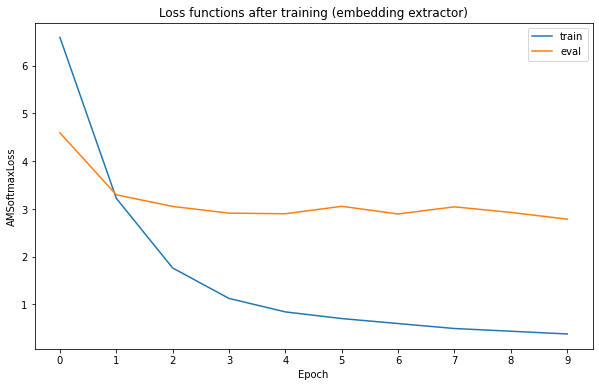

In [ ]:
plot_history(
    history_ext, 
    title="Loss functions after training (embedding extractor)",
    ylabel="AMSoftmaxLoss"
)

**Classifier training**
Skip this section if you're using pretrained model

In [ ]:
aed_extractor = EfficientNet_AED_Extractor('b0', 41, SAMPLE_RATE, n_mels=N_MELS, win_length=WIN_LEN, hop_length=HOP_LEN, n_fft=FFT_SIZE)
aed_extractor.load_state_dict(torch.load('/content/aed_extractor.pth')['model'])
aed_classifier = EfficientNet_AED_Classifier(n_classes=41, extractor=aed_extractor)

# Optimizer params
optimizer = optim.RMSprop(aed_classifier.parameters(), lr=LEARNING_RATE, momentum=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.8, mode='max')

criterion = nn.CrossEntropyLoss()

best_f1 = 0

aed_classifier, history_clf = train(
    aed_classifier, 
    train_loader, 
    eval_loader, 
    epoch_trainer=train_one_epoch_classifier,
    n_epochs=20, 
    device=DEVICE
)

Loaded pretrained weights for efficientnet-b0
Training: 1/20 epochs.


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


Eval F1-score: 0.7885753658448622
New best f1-score. Saving copy of the model.
Training: 2/20 epochs.


100%|██████████| 9/9 [00:11<00:00,  1.23s/it]

Eval F1-score: 0.7873713477209378
Training: 3/20 epochs.



100%|██████████| 9/9 [00:11<00:00,  1.27s/it]

Eval F1-score: 0.7875356955927706
Training: 4/20 epochs.



100%|██████████| 9/9 [00:11<00:00,  1.23s/it]

Eval F1-score: 0.7832328499195133
Training: 5/20 epochs.



100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


Eval F1-score: 0.7938097411756452
New best f1-score. Saving copy of the model.
Training: 6/20 epochs.


100%|██████████| 9/9 [00:11<00:00,  1.28s/it]

Eval F1-score: 0.7891152034979733
Training: 7/20 epochs.



100%|██████████| 9/9 [00:11<00:00,  1.25s/it]

Eval F1-score: 0.7937429314488422
Training: 8/20 epochs.



100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


Eval F1-score: 0.7939211273842681
New best f1-score. Saving copy of the model.
Training: 9/20 epochs.


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


Eval F1-score: 0.7955796115071455
New best f1-score. Saving copy of the model.
Training: 10/20 epochs.


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]

Eval F1-score: 0.7948000859878651
Training: 11/20 epochs.



100%|██████████| 9/9 [00:10<00:00,  1.14s/it]

Eval F1-score: 0.7913945651004078
Training: 12/20 epochs.



100%|██████████| 9/9 [00:11<00:00,  1.23s/it]

Eval F1-score: 0.7921472071789597
Training: 13/20 epochs.



100%|██████████| 9/9 [00:09<00:00,  1.10s/it]

Eval F1-score: 0.7934982146958772
Training: 14/20 epochs.



100%|██████████| 9/9 [00:10<00:00,  1.11s/it]

Eval F1-score: 0.7939258287644158
Training: 15/20 epochs.



100%|██████████| 9/9 [00:10<00:00,  1.16s/it]

Eval F1-score: 0.7947194488103883
Training: 16/20 epochs.



100%|██████████| 9/9 [00:10<00:00,  1.21s/it]

Eval F1-score: 0.7943729786980724
Training: 17/20 epochs.



100%|██████████| 9/9 [00:10<00:00,  1.12s/it]

Eval F1-score: 0.7868023837512982
Training: 18/20 epochs.



100%|██████████| 9/9 [00:09<00:00,  1.11s/it]

Eval F1-score: 0.7883452022837647
Training: 19/20 epochs.



100%|██████████| 9/9 [00:11<00:00,  1.27s/it]

Eval F1-score: 0.787289766421308
Training: 20/20 epochs.



100%|██████████| 9/9 [00:09<00:00,  1.11s/it]

Eval F1-score: 0.7864000382815178


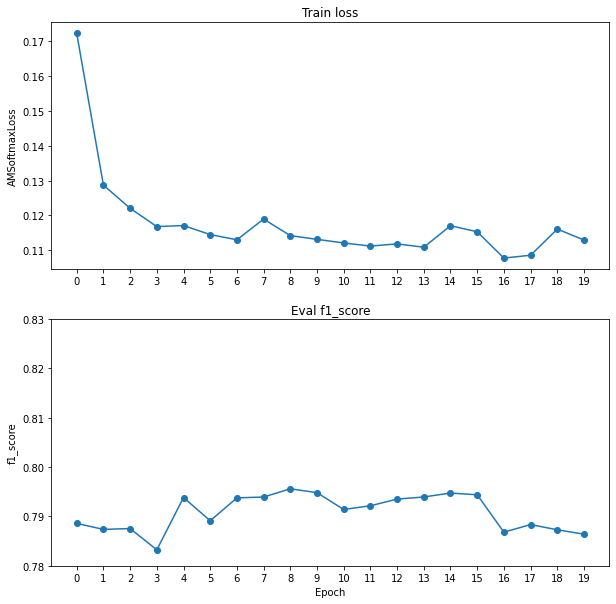

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title("Train loss")
ax[0].set_xticks(np.arange(len(history_clf['train_loss'])))
ax[0].set_ylabel("AMSoftmaxLoss")
ax[0].plot(history_clf['train_loss'], marker='o')

ax[1].set_title("Eval f1_score")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("f1_score")
ax[1].set_xticks(np.arange(len(history_clf['eval_loss'])))
ax[1].set_ylim(0.78, 0.83)
ax[1].plot(history_clf['eval_loss'], marker='o');

**Infer on eval and test sets**

In [ ]:
extractor = EfficientNet_AED_Extractor(
    efficient_net_version='b0',
    n_classes=41,
    sample_rate=SAMPLE_RATE,
    n_mels=N_MELS,
    win_length=WIN_LEN,
    hop_length=HOP_LEN,
    n_fft=FFT_SIZE,
)
# extractor.load_state_dict(torch.load('/kaggle/working/aed_extractor.pth')['model'])
aed_classifier = EfficientNet_AED_Classifier(NUM_CLASSES, extractor)
aed_classifier.load_state_dict(torch.load('/content/aed_classifier.pth', map_location=DEVICE)['model'])
aed_classifier.to(DEVICE);

Loaded pretrained weights for efficientnet-b0


In [ ]:
nn_eval_pred_probs = predict_classifier(aed_classifier, eval_loader, return_probs=True, device=DEVICE)
nn_eval_pred_probs = nn_eval_pred_probs[1]

100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


In [ ]:
eval_df['nn_pred'] = nn_eval_pred_probs.argmax(axis=1)
eval_df.head()

,fname,label,label_encoded,nn_pred
526,e1e3d20b7cb8bca1f727.wav,Tearing,9,39
3490,ab350b378b641f84184d.wav,Flute,23,23
5680,ac3177fbe1f9b0155920.wav,Cello,26,26
291,d526d3b0e32314a31178.wav,Hi-hat,27,27
1420,27ca396a62065c161130.wav,Tearing,9,11


In [ ]:
eval_y = eval_df['label_encoded'].values
print("F1 macro: %s" % f1_score(eval_y, nn_eval_pred_probs.argmax(axis=1), average='macro'))

F1 macro: 0.7955796115071455


**Make submission.csv**

In [ ]:
nn_test_pred_probs = predict_classifier(aed_classifier, test_loader, return_probs=True, device=DEVICE)
nn_test_pred_probs = nn_test_pred_probs[1]

100%|██████████| 30/30 [26:04<00:00, 52.15s/it]


In [ ]:
sample_submission_df['label'] = nn_test_pred_probs.argmax(axis=1)
sample_submission_df['label'] = sample_submission_df['label'].apply(lambda x: idx_to_class_dict[x])
if 'label_encoded' in sample_submission_df.columns:
    sample_submission_df = sample_submission_df.drop(columns=['label_encoded'])
sample_submission_df.to_csv('submision.csv', index=None)
sample_submission_df.head()

,fname,label
0,973a8b381d1875ebe120.wav,Knock
1,052e1cbeb4391d6af234.wav,Acoustic_guitar
2,16eb98d96319450e0949.wav,Knock
3,ff13c136c04f274229a5.wav,Knock
4,b458211304f7a14b29b2.wav,Cough
